# Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»

Задание к домашней работе

Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет [train.csv](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
Построить случайный лес, вывести важность признаков
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


In [85]:
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(
		model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores


In [86]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [87]:
X = df.drop(columns='SalePrice')
y = df[['SalePrice']]


In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)


In [89]:
# находим категориальные признаки

categorials = list(df.dtypes[df.dtypes == object].index)
categorials_nunique = X_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[categorials] = df[categorials].fillna('nan')


In [90]:
# фильтруем непрерывные признаки
integer = [f for f in df if f not in (categorials + ['ID', 'SalePrice'])]


In [91]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(X_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


In [92]:
# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([X_test[integer].fillna(-999), dummy_test], axis=1)


In [93]:
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)


<ipython-input-93-439793f9b51e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rf.fit(X_train, y_train)


RandomForestRegressor()

In [103]:
print('model score for train data:', clf_rf.score(X_train, y_train))
print('model score for train test:', clf_rf.score(X_test, y_test))

model score for train data: 0.9754606677817736
model score for train test: 0.8921835811477741


In [105]:
scores_train = evaluate_model(clf_rf, X_train, y_train)
scores_test = evaluate_model(clf_rf, X_test, y_test)

print('mean absolute error (MAE) for train:', np.mean(scores_train), np.std(scores_train))
print('mean absolute error (MAE) for test:', np.mean(scores_test), np.std(scores_test))


mean absolute error (MAE) for train: -18339.833994796623 2344.9478560898715
mean absolute error (MAE) for test: -19904.22242036646 3557.2036084882816


In [95]:
# наиболее важные признаки

imp = pd.Series(clf_rf.feature_importances_)


In [96]:
imp.index = pd.Series(X_train.columns)


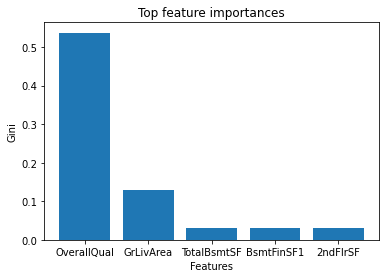

In [97]:
plt.title('Top feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index,
        imp.sort_values(ascending=False).head())
plt.show()


In [98]:
# Создаем стэккинг и обучаем его на наших данных

Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor()),
        ('SVM', SVR())
    ], RidgeCV())


In [99]:
Regressor.fit(X_train, y_train)


D:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor()),
                              ('SVM', SVR())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [100]:
print(f'Score on train data: {Regressor.score(X_train, y_train)}')
print(f'Score on test data: {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(
        f'Score on train data with model "{i}" = {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(
        f'Score on test data with model "{i}" = {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data: 0.9504677045403248
Score on test data: 0.87120523014074
Score on train data with model "LinearRegression" = 0.9221085403562432
Score on test data with model "LinearRegression" = 0.8533836050579315
Score on train data with model "KNeighborsRegressor" = 0.7419951520813983
Score on test data with model "KNeighborsRegressor" = 0.6775304068635524
Score on train data with model "DecisionTree" = 1.0
Score on test data with model "DecisionTree" = 0.7655443518178555
Score on train data with model "SVM" = -0.04387396175487779
Score on test data with model "SVM" = -0.03198239380278367


Линейная регрессия показала лучший результат. Модель Деревья решений переобучилась. Модель ближайшего соседа тоже не плохо справилась с задачей.

In [101]:
score_train = {}
score_test = {}

for i in Regressor.named_estimators:
    score_train[i] = Regressor.named_estimators_[i].score(X_train, y_train)
    score_test[i] = Regressor.named_estimators_[i].score(X_test, y_test)

score_train['Total'] = Regressor.score(X_train, y_train)
score_test['Total'] = Regressor.score(X_test, y_test)


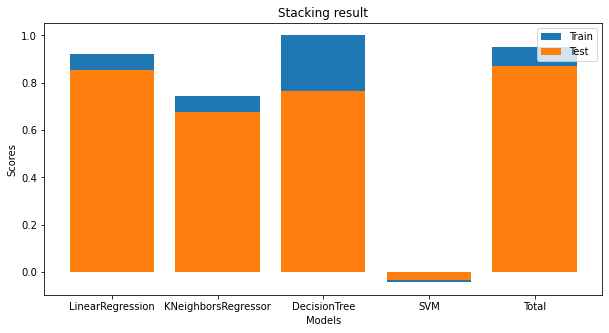

In [102]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(score_train)), score_train.values(),
        align="center", label='Train')
plt.xticks(range(len(score_train)), list(score_train.keys()))
plt.bar(range(len(score_test)), score_test.values(),
        align="center", label='Test')
plt.xticks(range(len(score_test)), list(score_test.keys()))
plt.autoscale
plt.title('Stacking result')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
